<a href="https://colab.research.google.com/github/DjFarmor/Markov_network_criticality/blob/main/Criticality2_0.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [53]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from scipy.stats import norm
from scipy.stats import entropy

# Network Viz class

In [54]:
class NetworkVisualization:
    """
    Parent class for network visualization and utility functions.
    """
    def plot_network_state(self, state, title="Network State"):
        """
        Plots the state of the network (e.g., node activities).

        Args:
            state (np.ndarray): A 1D or 2D array representing the network state.
            title (str, optional): The title of the plot. Defaults to "Network State".
        """
        plt.figure()
        plt.imshow(state, aspect='auto', cmap='viridis')
        plt.colorbar(label='Activity')
        plt.title(title)
        plt.xlabel("Nodes (or time steps)")
        plt.ylabel("Time steps (or nodes)")
        plt.show()

    def plot_connectivity_matrix(self, connectivity_matrix, title="Connectivity Matrix"):
        """
        Plots the connectivity matrix of the network.

        Args:
            connectivity_matrix (np.ndarray): A 2D array representing the connections between nodes.
            title (str, optional): The title of the plot. Defaults to "Connectivity Matrix".
        """
        plt.figure()
        sns.heatmap(connectivity_matrix, cmap='coolwarm', vmin=-1, vmax=1)
        plt.title(title)
        plt.xlabel("Target Node")
        plt.ylabel("Source Node")
        plt.show()

    def generate_random_noise(self, low, high, chance, size):
        """
        Generates random noise with a given chance.

        Args:
            low (float): The lower bound of the noise.
            high (float): The upper bound of the noise.
            chance (float): The probability (0 to 1) of adding noise to each element.
            size (tuple): The shape of the noise array to generate.

        Returns:
            np.ndarray: An array of random noise (or zeros where no noise is added).
        """
        noise = np.zeros(size)
        mask = np.random.rand(size) < chance
        noise[mask] = np.random.uniform(low, high, size=np.sum(mask))
        return noise

# Network analysis class

In [55]:
class NetworkAnalysis:
    """
    Parent class for network analysis measures.
    """
    def calculate_sparsity(self, connectivity_matrix):
        """
        Calculates the sparsity of the connectivity matrix.

        Args:
            connectivity_matrix (np.ndarray): A 2D array representing the connections.

        Returns:
            float: The proportion of zero connections in the matrix.
        """
        total_elements = connectivity_matrix.size
        zero_elements = np.sum(connectivity_matrix == 0)
        return zero_elements / total_elements

    def calculate_mean_degree(self, connectivity_matrix):
        """
        Calculates the mean degree of the network (assuming unweighted and undirected connections).

        Args:
            connectivity_matrix (np.ndarray): A 2D array representing the connections.

        Returns:
            float: The average number of connections per node.
        """
        # Consider a connection if the absolute weight is greater than a small threshold
        adjacency_matrix = (np.abs(connectivity_matrix) > 1e-9).astype(int)
        degrees = np.sum(adjacency_matrix, axis=1)
        return np.mean(degrees)

    def calculate_activity_mean(self, activity_over_time):
        """
        Calculates the mean activity of the network over time.

        Args:
            activity_over_time (np.ndarray): A 2D array where each row represents a time step
                                             and each column represents a node's activity.

        Returns:
            np.ndarray: A 1D array representing the mean activity of each node over time.
        """
        return np.mean(activity_over_time)

    def calculate_activity_ste(self, activity_over_time):
        """
        Calculates the standard deviation of the network activity over time.

        Args:
            activity_over_time (np.ndarray): A 2D array where each row represents a time step
                                             and each column represents a node's activity.

        Returns:
            np.ndarray: A 1D array representing the standard deviation of each node's activity over time.
        """
        return np.std(activity_over_time)/(np.sqrt(activity_over_time.size)-1)

    def calculate_lempel_ziv_complexity(self, activity_sequence):
        """
        Calculates the Lempel-Ziv complexity of a binary activity sequence.

        Args:
            activity_sequence (np.ndarray): A 1D binary array representing the
                                             activity of a single node over time.

        Returns:
            int: The Lempel-Ziv complexity.
        """
        activity_sequence = activity_sequence.flatten(order="F")
        s = "".join(map(str, activity_sequence.astype(int)))
        n = len(s)
        if n == 0:
            return 0
        distinct_substrings = set()
        length = 1
        position = 0
        while position < n:
            substring = s[position : position + length]
            if substring in distinct_substrings:
                length += 1
            else:
                distinct_substrings.add(substring)
                position += length
                length = 1
            if position + length >= n:
              break
        max_complexity = len(activity_sequence) / np.log2(len(activity_sequence))
        return len(distinct_substrings)/ max_complexity if max_complexity > 0 else 0.0

    def calculate_coalition_entropy(self, network_states):
        """
        Calculates the coalition entropy of the network states.

        Args:
            network_states (np.ndarray): A 2D binary array where each row
                                          represents the state of the network at a
                                          given time step (shape: (time_steps, num_nodes)).

        Returns:
            float: The coalition entropy.
        """
        num_time_steps = network_states.shape[0]
        if num_time_steps == 0:
            return 0.0
        unique_states, counts = np.unique(network_states, axis=0, return_counts=True)
        probabilities = counts / num_time_steps
        return entropy(probabilities, base=2)/self.num_nodes

    def calculate_branching_parameter(self, activity_history):
        """
        Calculates the branching parameter of the network activity.

        Args:
            activity_history (np.ndarray): A 2D binary array where each row
                                             represents the state of the network at a
                                             given time step (shape: (time_steps, num_nodes)).

        Returns:
            np.ndarray: A 1D array where each element represents the branching
                        parameter (ratio of active nodes at time t+1 to active
                        nodes at time t) for each time step (excluding the first).
        """
        active_nodes_t = np.sum(activity_history[:-1, :], axis=1)
        active_nodes_tp1 = np.sum(activity_history[1:, :], axis=1)
        # Avoid division by zero by replacing 0 with nan
        active_nodes_t[active_nodes_t == 0] = np.nan
        branching_param = active_nodes_tp1 / active_nodes_t
        return np.nanmean(branching_param)

    def calculate_baseline_activity(self, activity_history, window_size):
        """
        Calculates the moving average of the total network activity.

        Args:
            activity_history (np.ndarray): Binary activity data (time x nodes).
            window_size (int): The size of the moving average window.

        Returns:
            np.ndarray: The moving average of the number of active nodes over time.
        """
        active_nodes = np.sum(activity_history, axis=1)
        if window_size >= len(active_nodes):
            return np.full_like(active_nodes, np.mean(active_nodes))
        else:
            return np.convolve(active_nodes, np.ones(window_size), 'same') / window_size

    def identify_avalanches(self, activity_history, baseline_activity, threshold_factor=1.5, min_duration=2):
        """
        Identifies avalanche start and end times based on deviations from baseline.

        Args:
            activity_history (np.ndarray): Binary activity data (time x nodes).
            baseline_activity (np.ndarray): The baseline activity level over time.
            threshold_factor (float): Factor by which activity must exceed baseline.
            min_duration (int): Minimum duration for an event to be considered an avalanche.

        Returns:
            list: A list of tuples, where each tuple contains the (start_index, end_index)
                  of an identified avalanche.
        """
        active_nodes = np.sum(activity_history, axis=1)
        avalanches = []
        in_avalanche = False
        start_index = -1

        for t in range(len(active_nodes)):
            if active_nodes[t] > baseline_activity[t] * threshold_factor and not in_avalanche:
                in_avalanche = True
                start_index = t
            elif in_avalanche and active_nodes[t] <= baseline_activity[t]:
                in_avalanche = False
                if (t - start_index) >= min_duration:
                    avalanches.append((start_index, t))
                start_index = -1

        # Handle any avalanche that might be ongoing at the end of the simulation
        if in_avalanche and (len(active_nodes) - start_index) >= min_duration:
            avalanches.append((start_index, len(active_nodes)))

        return avalanches

    def calculate_branching_parameter_per_avalanche(self, activity_history, avalanches, epsilon=1e-9):
        """
        Calculates the branching parameter for each identified avalanche.

        Args:
            activity_history (np.ndarray): Binary activity data (time x nodes).
            avalanches (list): List of (start_index, end_index) tuples for avalanches.
            epsilon (float, optional): Small value to avoid division by zero.

        Returns:
            list: A list of branching parameter values, one for each avalanche.
        """
        avalanche_branching_params = []
        for start, end in avalanches:
            if start < end - 1:
                active_t = np.sum(activity_history[start:end-1], axis=1)
                active_tp1 = np.sum(activity_history[start+1:end], axis=1)
                branching_ratios = active_tp1 / (active_t + epsilon)
                avalanche_branching_params.append(np.mean(branching_ratios))
        return avalanche_branching_params

    def calculate_two_point_correlation(self, activity_history, max_lag=10):
        """
        Calculates the time-lagged two-point correlation of the network activity.

        Args:
            activity_history (np.ndarray): A 2D binary array of network states
                                             (shape: (time_steps, num_nodes)).
            max_lag (int, optional): The maximum time lag to consider. Defaults to 10.

        Returns:
            np.ndarray: A 2D array of shape (num_nodes, max_lag + 1) where each
                        element (i, lag) represents the correlation of node i's
                        activity with its own activity lagged by 'lag' time steps.
        """
        num_time_steps, num_nodes = activity_history.shape
        correlations = np.zeros((num_nodes, max_lag + 1))
        for i in range(num_nodes):
            for lag in range(max_lag + 1):
                if lag < num_time_steps:
                    trace1 = activity_history[:num_time_steps - lag, i]
                    trace2 = activity_history[lag:, i]
                    correlations[i, lag] = np.corrcoef(trace1, trace2)[0, 1] if len(trace1) > 1 else np.nan
                else:
                    correlations[i, lag] = np.nan
        return correlations

    def calculate_average_pairwise_mutual_information(self, activity_history):
        """
        Calculates the average pairwise mutual information between all nodes
        in the network over the given activity history.

        Args:
            activity_history (np.ndarray): A 2D binary array of network states
                                             (shape: (time_steps, num_nodes)).

        Returns:
            float: The average pairwise mutual information.
        """
        num_time_steps, num_nodes = activity_history.shape
        if num_nodes < 2 or num_time_steps == 0:
            return 0.0

        total_mutual_information = 0.0
        num_pairs = 0

        for i in range(num_nodes):
            for j in range(i + 1, num_nodes):
                p_xi_1 = np.mean(activity_history[:, i] == 1)
                p_xi_0 = 1 - p_xi_1
                p_xj_1 = np.mean(activity_history[:, j] == 1)
                p_xj_0 = 1 - p_xj_1

                p_xi1_xj1 = np.mean((activity_history[:, i] == 1) & (activity_history[:, j] == 1))
                p_xi1_xj0 = np.mean((activity_history[:, i] == 1) & (activity_history[:, j] == 0))
                p_xi0_xj1 = np.mean((activity_history[:, i] == 0) & (activity_history[:, j] == 1))
                p_xi0_xj0 = np.mean((activity_history[:, i] == 0) & (activity_history[:, j] == 0))

                # Avoid log of zero
                mi = 0.0
                if p_xi1_xj1 > 0:
                    mi += p_xi1_xj1 * np.log2(p_xi1_xj1 / (p_xi_1 * p_xj_1 + 1e-9))
                if p_xi1_xj0 > 0:
                    mi += p_xi1_xj0 * np.log2(p_xi1_xj0 / (p_xi_1 * p_xj_0 + 1e-9))
                if p_xi0_xj1 > 0:
                    mi += p_xi0_xj1 * np.log2(p_xi0_xj1 / (p_xi_0 * p_xj_1 + 1e-9))
                if p_xi0_xj0 > 0:
                    mi += p_xi0_xj0 * np.log2(p_xi0_xj0 / (p_xi_0 * p_xj_0 + 1e-9))

                total_mutual_information += mi
                num_pairs += 1

        return total_mutual_information / num_pairs if num_pairs > 0 else 0.0

    def calculate_avalanche_branching(self, activity_history, baseline_window_size, threshold_factor=1.5, min_duration=2, epsilon=1e-9):
        """
        Calculates the average branching parameter based on identified avalanches.

        Args:
            activity_history (np.ndarray): Binary activity data (time x nodes).
            baseline_window_size (int): The size of the moving average window for baseline activity.
            threshold_factor (float, optional): Factor by which activity must exceed baseline. Defaults to 1.5.
            min_duration (int, optional): Minimum duration for an event to be an avalanche. Defaults to 2.
            epsilon (float, optional): Small value to avoid division by zero. Defaults to 1e-9.

        Returns:
            float: The average branching parameter across all identified avalanches,
                   or NaN if no avalanches are found.
        """
        active_nodes = np.sum(activity_history, axis=1)
        if baseline_window_size >= len(active_nodes) or baseline_window_size <= 0:
            baseline_activity = np.full_like(active_nodes, np.mean(active_nodes) if active_nodes.size > 0 else 0)
        else:
            baseline_activity = np.convolve(active_nodes, np.ones(baseline_window_size), 'same') / baseline_window_size

        avalanches = []
        in_avalanche = False
        start_index = -1

        for t in range(len(active_nodes)):
            if active_nodes[t] > baseline_activity[t] * threshold_factor and not in_avalanche:
                in_avalanche = True
                start_index = t
            elif in_avalanche and active_nodes[t] <= baseline_activity[t]:
                in_avalanche = False
                if (t - start_index) >= min_duration:
                    avalanches.append((start_index, t))
                start_index = -1

        if in_avalanche and (len(active_nodes) - start_index) >= min_duration:
            avalanches.append((start_index, len(active_nodes)))

        avalanche_branching_params = []
        for start, end in avalanches:
            if start < end - 1:
                active_t = np.sum(activity_history[start:end-1], axis=1)
                active_tp1 = np.sum(activity_history[start+1:end], axis=1)
                branching_ratios = active_tp1 / (active_t + epsilon)
                avalanche_branching_params.append(np.mean(branching_ratios))

        return np.mean(avalanche_branching_params) if avalanche_branching_params else np.nan

# Markov network class

In [56]:
class BinaryMarkovNetwork(NetworkVisualization, NetworkAnalysis):
    """
    A network of binary nodes where the state at the next time step
    depends probabilistically on the current state and connections.
    """
    def __init__(self, num_nodes, excitatory_inhibitory_ratio, connection_density, neuronal_noise_chance=0.0, decay_rate=0, noise_size=(0,5)):
        """
        Initializes the BinaryMarkovNetwork.

        Args:
            num_nodes (int): The number of nodes in the network.
            excitatory_inhibitory_ratio (float): Ratio of excitatory/inhibitory connections (-1 to 1).
            connection_density (float): The probability (0 to 1) of a connection between any two nodes.
            neuronal_noise_chance (float, optional): The probability (0 to 1) of adding random noise
                                                   to a node's state update. Defaults to 0.0.
        """
        self.num_nodes = num_nodes
        self.excitatory_inhibitory_ratio = excitatory_inhibitory_ratio
        self.connection_density = connection_density
        self.neuronal_noise_chance = neuronal_noise_chance
        self.connectivity_matrix = self._generate_connectivity_matrix()
        self.state = np.random.randint(0, 2, size=num_nodes)  # Initialize with random binary states
        self.decay_rate = decay_rate
        self.noise_size = noise_size
    def _generate_connectivity_matrix(self):
        """
        Generates the connectivity matrix based on the network parameters.

        Returns:
            np.ndarray: A (num_nodes x num_nodes) connectivity matrix with weights
                        drawn from a normal distribution (mean 0, std 0.5), scaled
                        to achieve the desired excitatory/inhibitory ratio and density.
        """
        matrix = np.zeros((self.num_nodes, self.num_nodes))
        for i in range(self.num_nodes):
            for j in range(self.num_nodes):
               if i != j and np.random.rand() < self.connection_density: ## Allow self-connections
                    matrix[i,j] = norm.rvs(loc=self.excitatory_inhibitory_ratio, scale=0.5)

        return matrix

    def update_state(self, external_input=None):
        """
        Updates the state of the network based on the Markov process with decay.

        Args:
            external_input (np.ndarray, optional): An array of external inputs to each node.
                                                   Defaults to None.
            decay_rate (float, optional): A value between 0 and 1 representing the rate
                                         at which the node state decays towards 0. Defaults to 0.1.
        """
        # Apply decay
        self.state = self.state * (1 - self.decay_rate)

        # Next timestep
        weighted_input = np.dot(self.connectivity_matrix, self.state)

        # add input
        total_input = weighted_input + (external_input if external_input is not None else 0)

        # Combine decayed state and weighted input, then apply sigmoid
        probabilities = self._sigmoid(total_input + self.state)
        new_state = np.random.rand(self.num_nodes) < probabilities

        # Add neuronal noise
        noise = self.generate_random_noise(self.noise_size[0], self.noise_size[1], self.neuronal_noise_chance, self.num_nodes)
        new_state = (new_state + noise > 0.5).astype(int)

        self.state = new_state

    def _sigmoid(self, x):
        """
        Sigmoid activation function to get probabilities.

        Args:
            x (np.ndarray): Input array.

        Returns:
            np.ndarray: Output array with values between 0 and 1.
        """
        x = x - 1
        return 1 / (1 + np.exp(-5 * x))

    def generate_activity(self, time_steps, input_stream=None):
        """
        Generates a timeseries of network activity.

        Args:
            time_steps (int): The number of time steps to simulate.
            input_stream (np.ndarray, optional): An array representing the external input over time.
                                                 Should have a shape of (time_steps, num_nodes).
                                                 Each row corresponds to the input at a given time step.
                                                 Can be a string indicating a specific type of input
                                                 (e.g., "simulated external perturbation", "sensory inputs").
                                                 Defaults to None (no external input).

        Returns:
            np.ndarray: A (time_steps, num_nodes) array representing the network activity over time.
        """
        activity_history = np.zeros((time_steps, self.num_nodes))
        for t in range(time_steps):
            if isinstance(input_stream, np.ndarray):
                external_input = input_stream[t, :]
                self.update_state(external_input)
            elif isinstance(input_stream, str):
                external_input = self._handle_input_stream(input_stream, t)
                self.update_state(external_input)
            else:
                self.update_state()
            activity_history[t, :] = self.state
        return activity_history

    def _handle_input_stream(self, input_type, time_step):
        """
        Handles different types of input streams.

        Args:
            input_type (str): The type of input stream.
            time_step (int): The current time step.

        Returns:
            np.ndarray: An array representing the external input to each node at the current time step.
        """
        if input_type == "simulated external perturbation":
            # Example: Apply a brief perturbation to a subset of nodes
            perturbation = np.zeros(self.num_nodes)
            if 10 < time_step < 20:
                perturbation[0:int(self.num_nodes * 0.2)] = 1  # Perturb the first 20% of nodes
            return perturbation
        elif input_type == "sensory inputs":
            # Example: Simulate a repeating sensory input pattern
            input_pattern = np.sin(np.linspace(0, 2 * np.pi, self.num_nodes))
            return 0.5 * (input_pattern + 1)  # Scale to be between 0 and 1
        else:
            print(f"Warning: Unknown input stream type '{input_type}'. Returning zero input.")
            return np.zeros(self.num_nodes)

# Run stuff

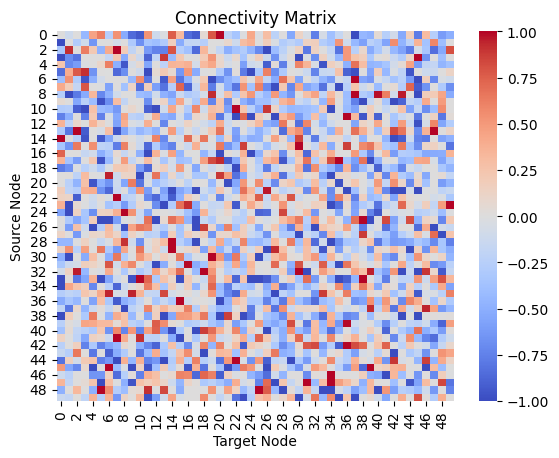

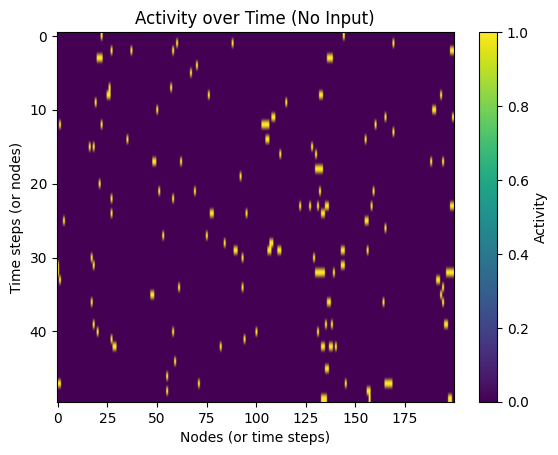

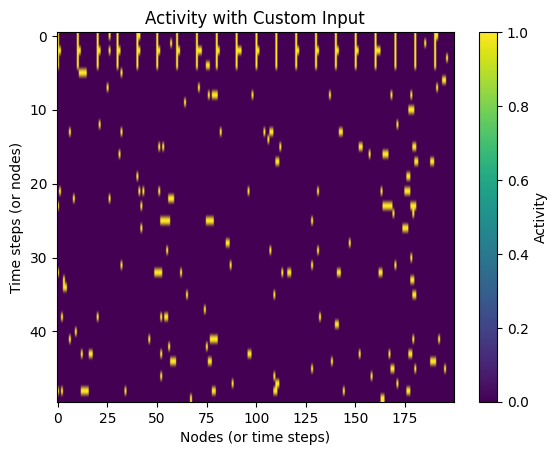

In [83]:
timesteps = 200
nodes = 50
eir = -0.11
conn_density = 0.9
noise_chance = 0.02
stim_freq = 10 # inverse (lower is faster)
stim_size = 10 # inverse (lower is bigger)
decay_rate = 0.3
noise_size = (-0.5,0.5)

custom_input = np.zeros((timesteps, 50))

for i in range(timesteps):
  if i % stim_freq == 0:
    custom_input[i, 0:int(nodes/stim_size)] = 10

network = BinaryMarkovNetwork(num_nodes=nodes,
                              excitatory_inhibitory_ratio=eir,
                              connection_density=conn_density,
                              neuronal_noise_chance=noise_chance,
                              decay_rate=decay_rate,
                              noise_size = noise_size)

network.plot_connectivity_matrix(network.connectivity_matrix, title="Connectivity Matrix")

activity = network.generate_activity(time_steps=timesteps)
network.plot_network_state(activity.T, title="Activity over Time (No Input)")

activity_stim = network.generate_activity(time_steps=timesteps, input_stream=custom_input)
network.plot_network_state(activity_stim.T, title="Activity with Custom Input")


# Single network analysis

In [58]:
lz_complexity = network.calculate_lempel_ziv_complexity(activity[:, 0]) # For the first node
coalition_entropy = network.calculate_coalition_entropy(activity)
branching = network.calculate_branching_parameter(activity)
two_point_corr = network.calculate_two_point_correlation(activity, max_lag=20)
avg_mi = network.calculate_average_pairwise_mutual_information(activity)
avalanche_bp = network.calculate_avalanche_branching(activity,
                                                     baseline_window_size=int(timesteps/1),
                                                     threshold_factor=1.8,
                                                     min_duration=4)

print(f"Lempel-Ziv Complexity (Node 0): {lz_complexity}")
print(f"Coalition Entropy: {coalition_entropy:.4f}")
print(f"Branching Parameter: {branching}")
print(f"Two-Point Correlation (Node 0, lags 0-5):\n{two_point_corr[0, :6].round(2)}")
print(f"Average Pairwise Mutual Information: {avg_mi:.4f}")
print(f"Average avalanche branching: {avalanche_bp:.4f}")

sparsity = network.calculate_sparsity(network.connectivity_matrix)
mean_degree = network.calculate_mean_degree(network.connectivity_matrix)
mean_activity = network.calculate_activity_mean(activity)

print(f"Sparsity: {sparsity:.3f}")
print(f"Mean Degree: {mean_degree:.3f}")
print(f"Mean Activity per Node: {mean_activity.round(2)}")

/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2922: RuntimeWarning: invalid value encountered in divide
  c /= stddev[:, None]
/usr/local/lib/python3.11/dist-packages/numpy/lib/_function_base_impl.py:2923: RuntimeWarning: invalid value encountered in divide
  c /= stddev[None, :]


Lempel-Ziv Complexity (Node 0): 0.9965784284662086
Coalition Entropy: 0.1325
Branching Parameter: 1.0999460696430392
Two-Point Correlation (Node 0, lags 0-5):
[ 1.   -0.02 -0.02 -0.02 -0.02 -0.02]
Average Pairwise Mutual Information: 0.0097
Average avalanche branching: 0.8674
Sparsity: 0.122
Mean Degree: 43.900
Mean Activity per Node: 0.12


# Look at activity and avalanches

Identified 1 avalanches.
Branching parameters per avalanche: [0.87]
Average branching parameter across avalanches: 0.867


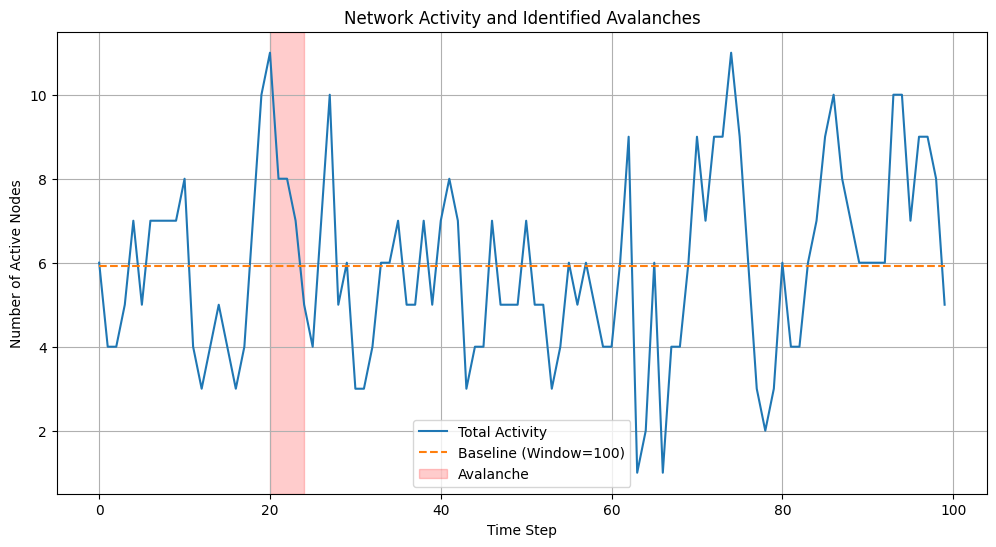

In [59]:

window = int(timesteps/1)  # Adjust as needed
baseline = network.calculate_baseline_activity(activity, window)

threshold = 1.8  # Adjust as needed
min_len = 4    # Adjust as needed
avalanche_events = network.identify_avalanches(activity, baseline, threshold, min_len)

if avalanche_events:
    avalanche_bp = network.calculate_branching_parameter_per_avalanche(activity, avalanche_events)
    print(f"Identified {len(avalanche_events)} avalanches.")
    print(f"Branching parameters per avalanche: {np.array(avalanche_bp).round(2)}")
    print(f"Average branching parameter across avalanches: {np.mean(avalanche_bp):.3f}")
else:
    print("No avalanches identified based on the criteria.")

# You could also visualize the activity and the identified avalanches
import matplotlib.pyplot as plt

active_nodes_over_time = np.sum(activity, axis=1)
time = np.arange(len(active_nodes_over_time))

plt.figure(figsize=(12, 6))
plt.plot(time, active_nodes_over_time, label='Total Activity')
plt.plot(time, baseline, label=f'Baseline (Window={window})', linestyle='--')
for start, end in avalanche_events:
    plt.axvspan(start, end, color='red', alpha=0.2, label='Avalanche' if start == avalanche_events[0][0] else None)
plt.xlabel('Time Step')
plt.ylabel('Number of Active Nodes')
plt.title('Network Activity and Identified Avalanches')
plt.legend()
plt.grid(True)
plt.show()

# Analysis over variable excitation/inhibition ratio

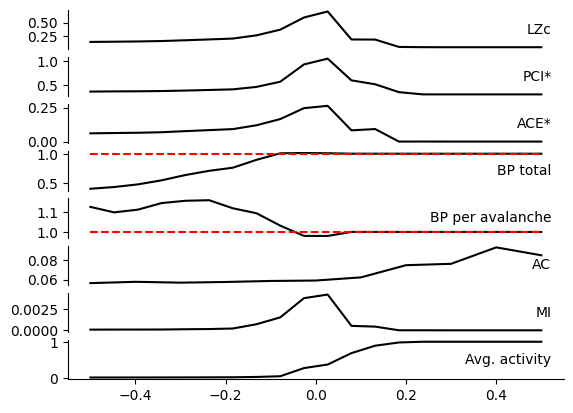

In [75]:
# Example usage
timesteps = 10000
nodes = 50
eir = np.linspace(-0.5,0.5,20)
conn_density = 0.9
noise_chance = 0.02
stim_freq = 50 # per x timestep
stim_size = 5 # inverse (lower is bigger)
decay_rate = 0.3
noise_size = (-0.5,0.5)

custom_input = np.zeros((timesteps, 50)) # Example: 120 time steps, 50 nodes
for i in range(timesteps):
  if i % stim_freq == 0:
    custom_input[i, 0:int(nodes/stim_size)] = 20

results = {"LZc":[],
           "PCI*":[],
           "ACE*":[],
           "BP total":[],
           "BP per avalanche":[],
           "AC":[],
           "MI":[],
  #         "sparsity":[],
  #         "mean_degree":[],
           "Avg. activity":[],}

for eir_val in eir:
  network = BinaryMarkovNetwork(num_nodes=nodes,
                                excitatory_inhibitory_ratio=eir_val,
                                connection_density=conn_density,
                                neuronal_noise_chance=noise_chance,
                                decay_rate=decay_rate,
                                noise_size = noise_size)

  activity = network.generate_activity(time_steps=timesteps)



  results["LZc"].append(np.mean(network.calculate_lempel_ziv_complexity(activity)))
  results["ACE*"].append(network.calculate_coalition_entropy(activity))
  results["BP total"].append(network.calculate_branching_parameter(activity))
  results["AC"].append(np.mean(network.calculate_two_point_correlation(activity, max_lag=20)))
  results["MI"].append(network.calculate_average_pairwise_mutual_information(activity))
  results["BP per avalanche"].append(network.calculate_avalanche_branching(activity,
                                                      baseline_window_size=int(timesteps/2),
                                                      threshold_factor=1.5,
                                                      min_duration=4))

#  results["sparsity"].append(network.calculate_sparsity(network.connectivity_matrix))
#  results["mean_degree"].append(network.calculate_mean_degree(network.connectivity_matrix))
  results["Avg. activity"].append(network.calculate_activity_mean(activity))

  activity_with_custom_input = network.generate_activity(time_steps=timesteps, input_stream=custom_input)
  results["PCI*"].append(np.mean([network.calculate_lempel_ziv_complexity(activity[stim_freq*x:stim_freq*x + stim_freq-1, :]) for x in range(1,int(timesteps/stim_freq)-1)]))

keys = list(results.keys())
fig, ax = plt.subplots(len(keys))
i = 0
for a in keys:
  ax[i].plot(eir, results[a], "k", label=a)

  if a == "BP per avalanche" or a == "BP total":
    ax[i].plot(eir,np.ones(len(eir)), "r--")

  if not i >= len(keys)-1:
    ax[i].tick_params(axis='x', which='both', bottom=False, top=False, labelbottom=True)
    ax[i].spines["bottom"].set_visible(False)

  ax[i].spines['top'].set_visible(False)
  ax[i].spines['right'].set_visible(False)

  legend = ax[i].legend(handlelength=0, handletextpad=0, frameon=False, loc='upper right')

  i+=1
plt.show()